# Analyze different image processing methods from grayscaling to contour methods

## Set-Up

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Analyze Blur Filter

In [21]:
img = cv2.imread("./data/001_1.png")

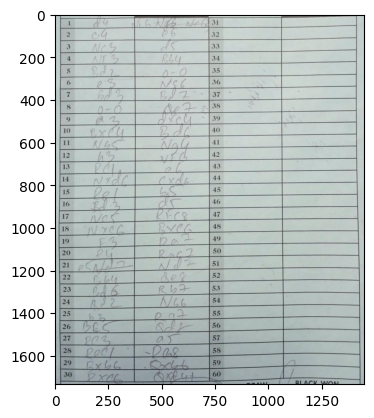

In [20]:
plt.imshow(img)

In [22]:
# https://www.youtube.com/watch?v=eNIrnHasZNI&t=557s
imgBlur = cv2.GaussianBlur(img, (21, 21), 3)

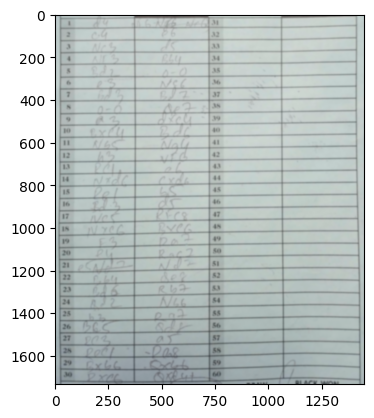

In [23]:
plt.imshow(imgBlur)

## Analyze line detection

In [5]:
img = cv2.imread("./data/001_1.png")

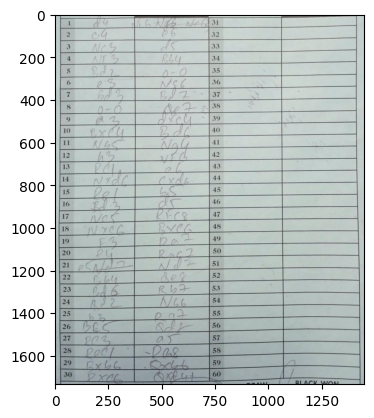

In [10]:
plt.imshow(img)

In [12]:
# https://www.youtube.com/watch?v=eNIrnHasZNI&t=557s
imgBlur = cv2.GaussianBlur(img, (21, 21), 3)

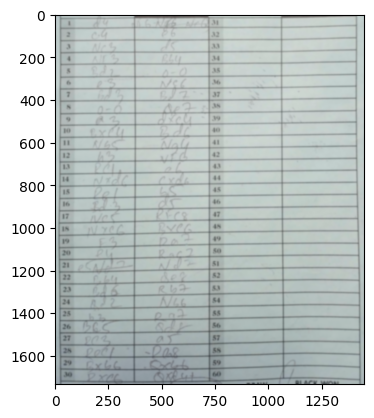

In [13]:
plt.imshow(imgBlur)

In [14]:
cannyEdge = cv2.Canny(imgBlur, 50, 180)

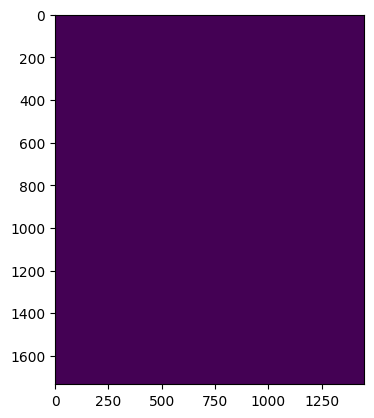

In [15]:
plt.imshow(cannyEdge)

In [18]:
distResol = 1
angleResol = np.pi/180
threshold = 300
lines = cv2.HoughLines(cannyEdge, distResol, angleResol, threshold)
k = 3000

In [ ]:
for curLine in lines:
    rho,theta = curLine[0]
    dhat = np.array([[np.cos(theta)], [np.sin(theta)]])
    d = rho*dhat
    lhat = np.array([[-np.sin(theta)], [np.cos(theta)]])
    p1 = d + k*lhat
    p2 = d - k*lhat
    p1 = p1.astype(int)
    p2 = p2.astype(int)
    cv2.line(img, (p1[0][0], p1[1][0]), (p2[0][0],p2[1][0]), (0, 0, 0), 10)
    print(f"{(p1[0][0], p1[1][0]), (p2[0][0],p2[1][0])}")

plt.imshow(img)

plt.show()

## Analyze Morphological Operations

In [24]:
img = cv2.imread("./data/001_1.png")

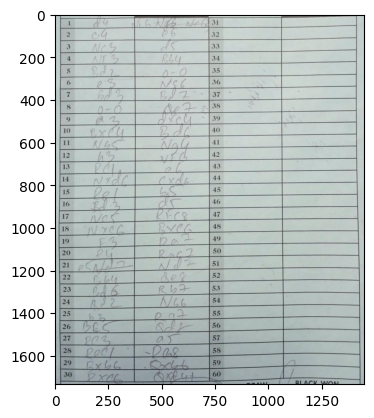

In [25]:
plt.imshow(img)

In [ ]:
# grayscale image

In [ ]:
# binaries image

In [ ]:
import cv2
import numpy as np

# Lade das binäre Bild (0 = schwarz, 255 = weiß)
img = np.array(img)

# Invertiere, falls nötig (damit Linien weiß sind)
img = 255 - img

# Bilddimensionen
height, width = img.shape

# Definiere lange, dünne Kernel
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(width / 15), 1))
vertical_kernel   = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(height / 15)))

# Morphologische Operationen (Erosion gefolgt von Dilation = Öffnung)
horizontal_lines = cv2.erode(img, horizontal_kernel, iterations=1)
horizontal_lines = cv2.dilate(horizontal_lines, horizontal_kernel, iterations=1)

vertical_lines = cv2.erode(img, vertical_kernel, iterations=1)
vertical_lines = cv2.dilate(vertical_lines, vertical_kernel, iterations=1)

# Optional: kombiniere beide
grid_lines = cv2.addWeighted(horizontal_lines, 0.5, vertical_lines, 0.5, 0)

# Zeige das Ergebnis
plt.imshow(grid_lines, cmap='gray')

In [ ]:
import cv2
import numpy as np

# 1. Lade dein Binärbild (muss schwarz/weiß sein: 0 oder 255)
img = np.array(img)

# 2. Invertieren (optional, falls Linien weiß sind)
img = cv2.bitwise_not(img)

# 3. Kernel-Größe basierend auf Bildgröße
h_kernel_len = img.shape[1] // 40  # horizontal (breit, flach)
v_kernel_len = img.shape[0] // 40  # vertikal (hoch, schmal)

# 4. Structuring Elements (Kernels)
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (h_kernel_len, 1))
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, v_kernel_len))

# 5. Morphologische Operationen
horizontal_lines = cv2.erode(img, horizontal_kernel, iterations=1)
horizontal_lines = cv2.dilate(horizontal_lines, horizontal_kernel, iterations=1)

vertical_lines = cv2.erode(img, vertical_kernel, iterations=1)
vertical_lines = cv2.dilate(vertical_lines, vertical_kernel, iterations=1)

# 6. Optional: Kombiniere beide Linienbilder
grid = cv2.add(horizontal_lines, vertical_lines)

# 7. Zeige oder speichere die Bilder
cv2.imshow("Horizontal Lines", horizontal_lines)
cv2.imshow("Vertical Lines", vertical_lines)
cv2.imshow("Grid", grid)
cv2.waitKey(0)
cv2.destroyAllWindows()